In [1]:
import pandas_datareader.data as web
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
from stock import Stock


In [21]:
start = datetime.datetime(1928, 1, 1)
end = datetime.date.today()
spyData = Stock('^GSPC', start, end)
spyData.stockData = spyData.stockData.iloc[250:]

spyData.stockData.head()


,Close,Volume,MA20,MA60,MA120,MA250,EMA20,EMA60,EMA120,EMA250,MAScore,PriceScore,SumScore,Chg,%Chg
Date,,,,,,,,,,,,,,,
1929-01-02,24.81,0,23.1925,22.684667,21.405583,19.96540,23.444937,22.695886,21.731696,19.976027,100.0,100.0,100.0,0.46,1.89%
1929-01-03,24.86,0,23.2400,22.744667,21.454833,19.99396,23.579705,22.766841,21.783404,20.014943,100.0,100.0,100.0,0.05,0.2%
1929-01-04,24.85,0,23.2920,22.805167,21.505167,20.02316,23.700686,22.835141,21.834091,20.053470,100.0,100.0,100.0,-0.01,-0.04%
1929-01-07,24.25,0,23.3590,22.857500,21.549250,20.04952,23.753001,22.881530,21.874024,20.086908,100.0,100.0,100.0,-0.6,-2.41%
1929-01-08,24.17,0,23.4495,22.907333,21.594833,20.07620,23.792715,22.923775,21.911974,20.119443,100.0,100.0,100.0,-0.08,-0.33%


In [130]:
class Period:
    def __init__(self):
        self.startIndex = None
        self.startDate = None
        self.startPrice = None
        self.endIndex = None
        self.endDate = None
        self.endPrice = None

    def __str__(self):
        deltaDays=self.endDate-self.startDate
        if deltaDays.days < 20:
            return ""
        period=deltaDays.days
        priceDiff = (self.endPrice-self.startPrice)*100/self.startPrice
        return "Bear period from {startIndex}-----{startDate}--{startPrice} $ to {endIndex}----{endDate}--{endPrice} $, period is {period} days and lost is {priceDiff} %".format(startIndex=self.startIndex, startDate=str(self.startDate)[0:10], startPrice= self.startPrice,endIndex= self.endIndex,endDate=str(self.endDate)[0:10], endPrice=self.endPrice,period=period,priceDiff=priceDiff)


bearPeriod = []
isbearPeriod = False
for i in range(len(spyData.stockData)):
    if not isbearPeriod:
        if spyData.stockData.iloc[i]['SumScore'] < 50:
            isbearPeriod = True
            newPeriod = Period()
            newPeriod.startIndex = i
            newPeriod.startDate = spyData.stockData.index[i]
            newPeriod.startPrice = spyData.stockData.iloc[i]['Close']
            bearPeriod.append(newPeriod)
            continue
        else:
            continue
    else:
        if spyData.stockData.iloc[i]['SumScore'] >= 50:
            isbearPeriod = False
            period = bearPeriod[-1]
            period.endIndex = i
            period.endDate = spyData.stockData.index[i]
            period.endPrice = spyData.stockData.iloc[i]['Close']
            continue
        else:
            continue
for period in bearPeriod:
    print(period)


Bear period from 214-----1929-11-08--21.18 $ to 322----1930-04-16--25.56 $, period is 159 days and lost is 20.679886685552404 %

Bear period from 329-----1930-04-28--24.76 $ to 922----1932-09-06--8.91 $, period is 862 days and lost is -64.01453957996769 %

Bear period from 936-----1932-09-26--8.04 $ to 952----1932-10-19--7.4 $, period is 23 days and lost is -7.96019900497511 %
Bear period from 953-----1932-10-20--7.23 $ to 1010----1933-01-13--7.25 $, period is 85 days and lost is 0.27662517289072713 %


Bear period from 1021-----1933-01-30--6.98 $ to 1072----1933-04-25--7.72 $, period is 85 days and lost is 10.601719197707725 %

Bear period from 1341-----1934-05-22--9.65 $ to 1358----1934-06-15--10.23 $, period is 24 days and lost is 6.010362694300519 %
Bear period from 1359-----1934-06-18--10.37 $ to 1582----1935-05-10--9.75 $, period is 326 days and lost is -5.978784956605586 %


Bear period from 2094-----1937-05-25--16.25 $ to 2134----1937-07-22--16.87 $, period is 58 days and lost 

In [115]:
period1 = Period()
period1.startIndex = 3

mylist=[]
mylist.append(period1)
print(mylist[0])
period=mylist[-1]
period.startIndex=55
print(mylist[0])

Bear period from 3-----None:None $ to None----None:None $

Bear period from 55-----None:None $ to None----None:None $



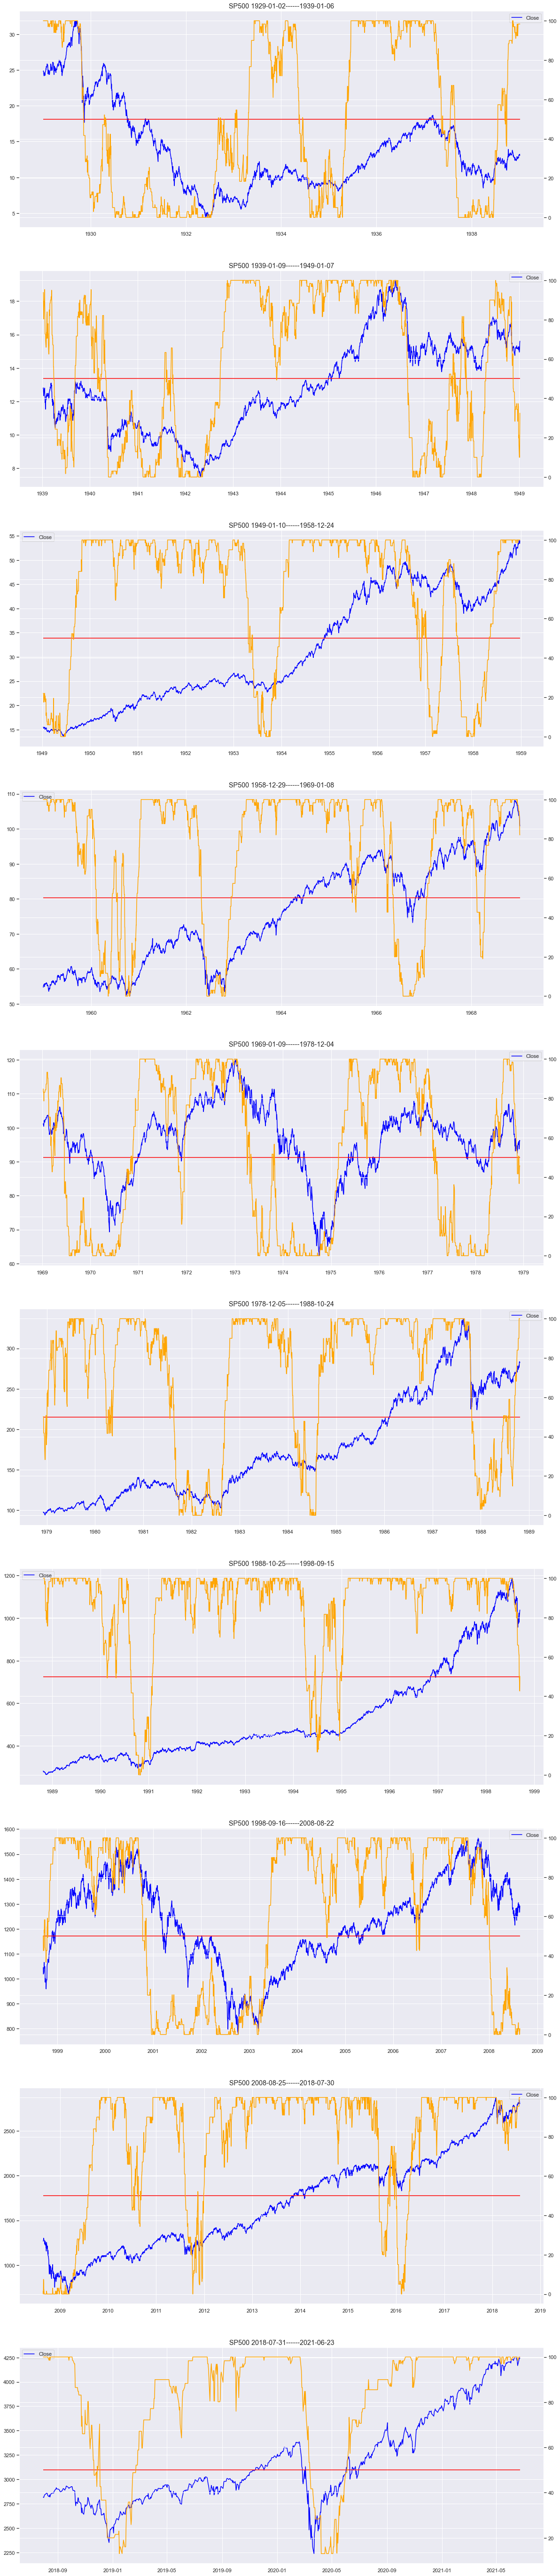

In [79]:
fig, axes = plt.subplots(10, 1, figsize=(20, 100))
for i in range(10):
    data = spyData.stockData.iloc[i*2500:(i+1)*2500]
    axes[i].plot(data.index, data['Close'], label='Close', color='blue')
    axes[i].twinx()
    plt.plot(data.index, data['SumScore'], label='Score', color='orange')
    axes[i].legend()
    plt.hlines(y=50, xmin=data.index[0], xmax=data.index[-1], colors='red')
    plt.title("SP500 " + str(data.index[0])[0:10] +
              "------"+str(data.index[-1])[0:10], fontsize='large')


In [80]:

increaseRate = 0.02
amount = 5000
Index = 0
cycle = 20
sharePrice = spyData.stockData.values[Index][0]
shares = round(amount/sharePrice)
shareValue = shares*sharePrice
ininData = [[spyData.stockData.index[Index], shareValue, 0, Index, sharePrice, 0,
             shares, shares, shareValue, shareValue, shareValue, sharePrice, 0, 0]]
dfValueAverage = pd.DataFrame(ininData, columns=['Date', 'TargetShareValue', 'ShareValueBeforePurchase', 'PriceIndex', 'SharePrice',  'newEarning', 'DeltaShare', 'Shares',
                                                 'PurchaseValue', 'ShareValue', 'Cost', 'ShareCost', 'Earning', 'EarningRate'])
index = dfValueAverage.iloc[0]['PriceIndex']


In [81]:
dfValueAverage


,Date,TargetShareValue,ShareValueBeforePurchase,PriceIndex,SharePrice,newEarning,DeltaShare,Shares,PurchaseValue,ShareValue,Cost,ShareCost,Earning,EarningRate
0,1929-01-02,5011.62,0,0,24.81,0,202,202,5011.62,5011.62,5011.62,24.81,0,0


In [82]:
i = 1
while Index < len(spyData.stockData)-cycle:
    previousData = dfValueAverage.iloc[i-1]
    Index = previousData['PriceIndex']+cycle
    currentSharePrice = spyData.stockData.values[Index][0]
    currentShareValueBeforePurchase = currentSharePrice*previousData['Shares']
    newEarning = currentShareValueBeforePurchase-previousData['ShareValue']
    targetShareValue = previousData['ShareValue']*(1+increaseRate)
    deltaShare = math.ceil(
        (targetShareValue-currentShareValueBeforePurchase)/currentSharePrice)
    currentShares = previousData['Shares']+deltaShare
    purchaceValue = deltaShare*currentSharePrice
    currentCost = previousData['Cost']+purchaceValue
    currentShareValue = currentShares*currentSharePrice
    currentEarning = currentShareValue-currentCost
    currentEarningRate = currentEarning*100/currentCost
    shareCost = currentCost/currentShares
    newData = [spyData.stockData.index[Index], targetShareValue, currentShareValueBeforePurchase, Index, currentSharePrice, newEarning, deltaShare, currentShares,
               purchaceValue, currentShareValue, currentCost, shareCost, currentEarning, currentEarningRate]
    dfValueAverage.loc[i] = newData
    i = i+1


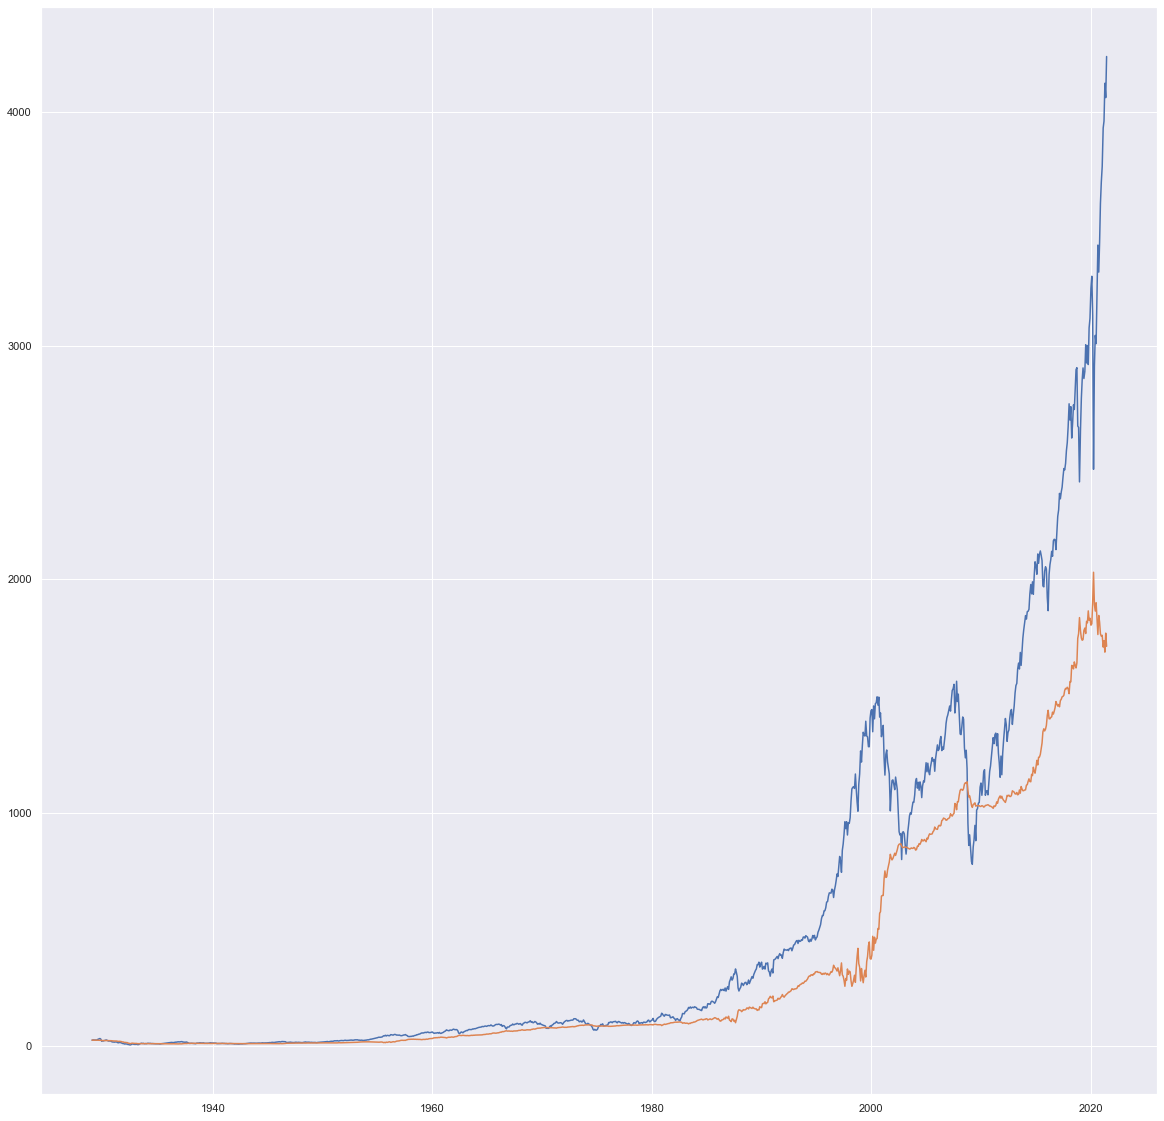

In [83]:
plt.figure(figsize=(20, 20))
plt.plot(dfValueAverage['Date'], dfValueAverage['SharePrice'])
plt.plot(dfValueAverage['Date'], dfValueAverage['ShareCost'])


In [91]:
increaseAmount = 600
Index = 0
cycle = 20
sharePrice = spyData.stockData.values[Index][0]
shares = math.ceil(increaseAmount/sharePrice)
shareValue = shares*sharePrice
ininData = [[spyData.stockData.index[Index],  0, Index, sharePrice, 0,
             shares, shares, shareValue, shareValue, shareValue, sharePrice, 0, 0]]
dfCurrencyAverage = pd.DataFrame(ininData, columns=['Date',  'ShareValueBeforePurchase', 'PriceIndex', 'SharePrice',  'newEarning', 'DeltaShare', 'Shares',
                                                    'PurchaseValue', 'ShareValue', 'Cost', 'ShareCost', 'Earning', 'EarningRate'])
index = dfCurrencyAverage.iloc[0]['PriceIndex']
dfCurrencyAverage


,Date,ShareValueBeforePurchase,PriceIndex,SharePrice,newEarning,DeltaShare,Shares,PurchaseValue,ShareValue,Cost,ShareCost,Earning,EarningRate
0,1929-01-02,0,0,24.81,0,25,25,620.25,620.25,620.25,24.81,0,0


In [95]:
i = 1
while Index < len(spyData.stockData)-cycle:
    previousData = dfCurrencyAverage.iloc[i-1]
    Index = previousData['PriceIndex']+cycle
    currentSharePrice = spyData.stockData.values[Index][0]
    currentShareValueBeforePurchase = currentSharePrice*previousData['Shares']
    newEarning = currentShareValueBeforePurchase-previousData['ShareValue']
    deltaShare = math.ceil(increaseAmount/currentSharePrice)
    currentShares = previousData['Shares']+deltaShare
    purchaceValue = deltaShare*currentSharePrice
    currentCost = previousData['Cost']+purchaceValue
    currentShareValue = currentShares*currentSharePrice
    currentEarning = currentShareValue-currentCost
    currentEarningRate = currentEarning*100/currentCost
    shareCost = currentCost/currentShares
    newData = [spyData.stockData.index[Index],  currentShareValueBeforePurchase, Index, currentSharePrice, newEarning, deltaShare, currentShares,
               purchaceValue, currentShareValue, currentCost, shareCost, currentEarning, currentEarningRate]
    dfCurrencyAverage.loc[i] = newData
    i = i+1

dfCurrencyAverage


,Date,ShareValueBeforePurchase,PriceIndex,SharePrice,newEarning,DeltaShare,Shares,PurchaseValue,ShareValue,Cost,ShareCost,Earning,EarningRate
0,1929-01-02,0.00,0,24.81,0.00,25,25,620.25,620.25,620.25,24.810000,0.00,0.000000
1,1929-01-30,636.25,20,25.45,16.00,24,49,610.80,1247.05,1231.05,25.123469,16.00,1.299704
2,1929-03-01,1265.67,40,25.83,18.62,24,73,619.92,1885.59,1850.97,25.355753,34.62,1.870371
3,1929-04-01,1816.24,60,24.88,-69.35,25,98,622.00,2438.24,2472.97,25.234388,-34.73,-1.404384
4,1929-04-29,2501.94,80,25.53,63.70,24,122,612.72,3114.66,3085.69,25.292541,28.97,0.938850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,2021-02-16,72638869.89,23140,3932.59,3035524.14,1,18472,3932.59,72642802.48,1045458.21,56.596915,71597344.27,6848.417621
1158,2021-03-16,73199179.12,23160,3962.71,556376.64,1,18473,3962.71,73203141.83,1049420.92,56.808365,72153720.91,6875.574856
1159,2021-04-14,76194844.18,23180,4124.66,2991702.35,1,18474,4124.66,76198968.84,1053545.58,57.028558,75145423.26,7132.621947
1160,2021-05-12,75060600.96,23200,4063.04,-1138367.88,1,18475,4063.04,75064664.00,1057608.62,57.245392,74007055.38,6997.584360


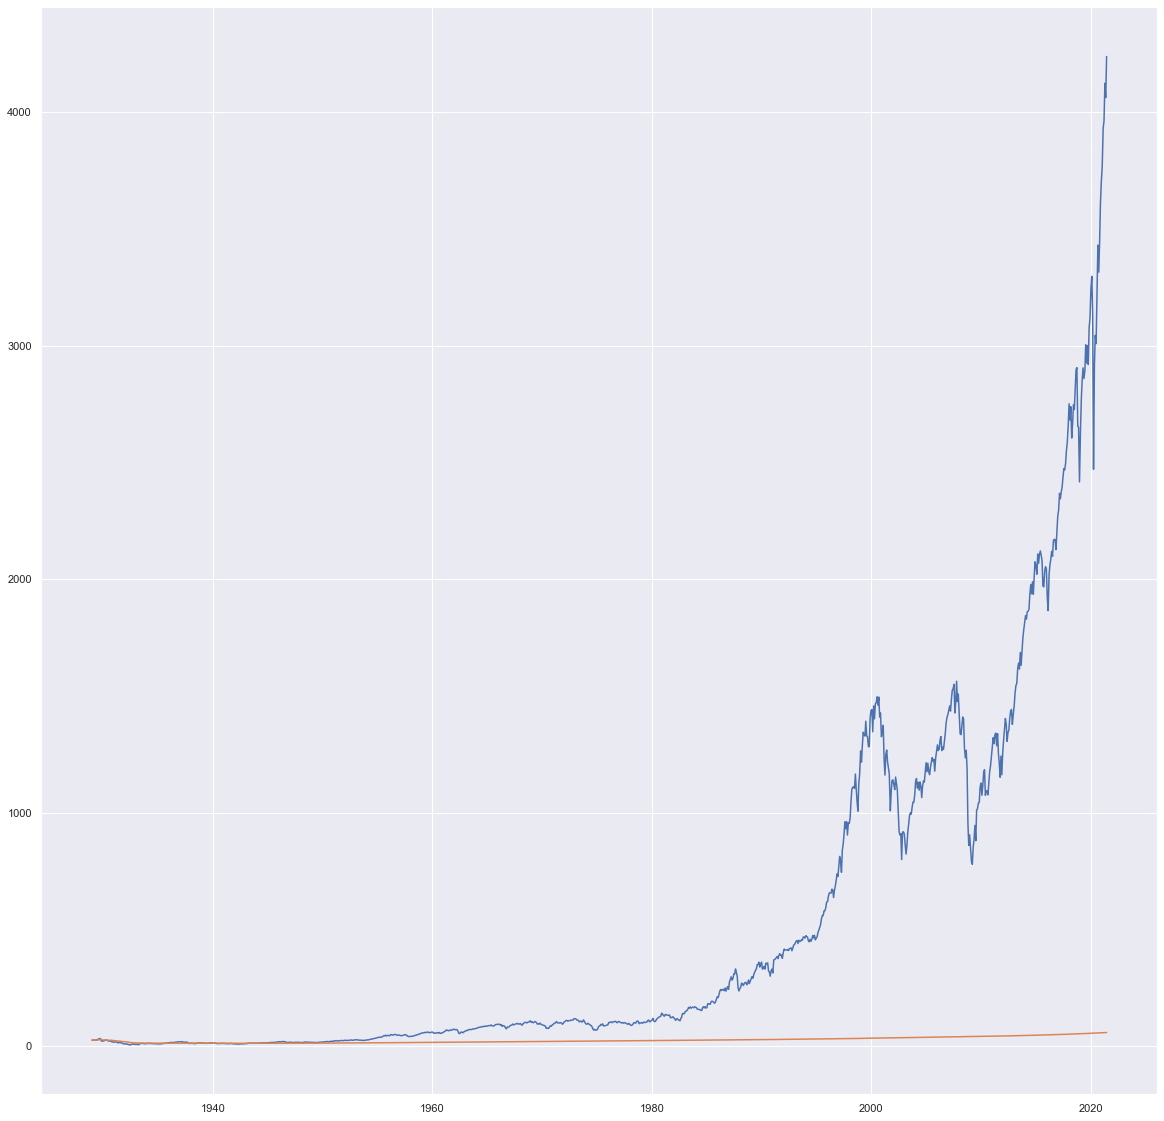

In [96]:

plt.figure(figsize=(20, 20))
plt.plot(dfCurrencyAverage['Date'], dfCurrencyAverage['SharePrice'])
plt.plot(dfCurrencyAverage['Date'], dfCurrencyAverage['ShareCost'])


In [97]:
start = datetime.datetime(1928, 1, 1)
end = datetime.date.today()
spyHis = web.DataReader('^GSPC', 'yahoo', start, end)[['Close']]
spyHis.head()


,Close
Date,
1928-01-03,17.760000
1928-01-04,17.719999
1928-01-05,17.549999
1928-01-06,17.660000
1928-01-09,17.500000
